In [6]:
!pip install -r ./requirements.txt

     |################################| 421.8 MB 5.2 MB/s eta 0:00:01   |                                | 2.5 MB 1.3 MB/s eta 0:05:23     |###                             | 40.9 MB 3.8 MB/s eta 0:01:41     |###                             | 48.1 MB 4.4 MB/s eta 0:01:26     |###                             | 48.8 MB 2.7 MB/s eta 0:02:16     |#####                           | 71.3 MB 5.0 MB/s eta 0:01:11     |#####                           | 78.9 MB 6.4 MB/s eta 0:00:54     |#######                         | 92.4 MB 1.7 MB/s eta 0:03:12     |########                        | 106.4 MB 3.6 MB/s eta 0:01:27     |###########                     | 154.1 MB 4.3 MB/s eta 0:01:02     |##############                  | 187.8 MB 4.2 MB/s eta 0:00:56     |##############                  | 188.8 MB 4.2 MB/s eta 0:00:56     |##############                  | 192.0 MB 3.4 MB/s eta 0:01:09     |###############                 | 198.7 MB 3.0 MB/s eta 0:01:16     |################                | 214.

In [1]:
from runnertools import runner_io

args_file:/usr/local/qai/args/args.json


In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import pickle

import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# matplotlibの基本設定
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# オブジェクト準備
loss_object = tf.keras.losses.CategoricalCrossentropy()

### 【☆runner_ioの処理】パラメータ

In [4]:
# パラメータ準備
epsilon = runner_io.arg('epsilon')

### 【☆runner_ioの処理】モデル

In [7]:
# model読み込み
model_path = runner_io.inventory('model_inventory')[0]
model = tf.keras.models.load_model(model_path, compile=False)

### 【☆runner_ioの処理】データ(ラベル表)読み込み

In [8]:
# ラベル表読み込み
label_path = runner_io.inventory('data_label_inventory')[0]
with open(label_path, mode='rb') as f:
     labels = pickle.load(f)

In [9]:
# 関数定義
## 画像読み込み
def read_image(image_path):
  image_raw = tf.io.read_file(image_path)
  image = tf.image.decode_image(image_raw)

  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

In [10]:
## 敵対的サンプル生成
def create_adversarial_image(input_image, image_probs):
  labrador_retriever_index = 208
  label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(label, prediction)

  gradient = tape.gradient(loss, input_image) # Get the gradients of the loss w.r.t to the input image.
  signed_grad = tf.sign(gradient) # Get the sign of the gradients to create the perturbation

  adv_image = input_image + epsilon*signed_grad
  adv_image = tf.clip_by_value(adv_image, 0, 1)
  
  return adv_image

### 【☆runner_ioの処理】データ(画像)読み込み

In [20]:
# 画像読み込み
image_path = runner_io.inventory('data_image_inventory')[0]
image_name = os.path.basename(image_path)
image = read_image(image_path)

In [14]:
# 推論
image_probs = model.predict(image)

### 結果出力+【☆runner_ioの処理】データ(画像)読み込み

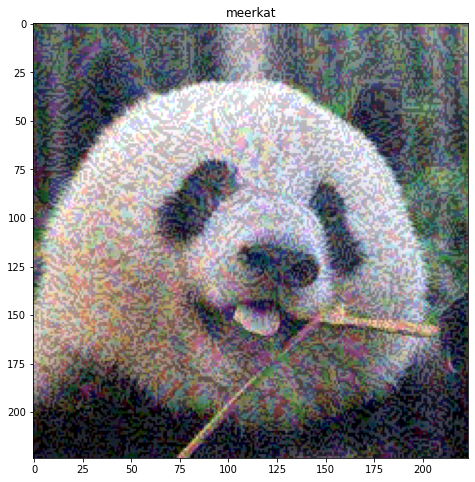

In [41]:
# 敵対的サンプル生成
adv_x = create_adversarial_image(image, image_probs)

label = labels[np.argmax(model.predict(adv_x))]
plt.figure()
plt.imshow(adv_x[0])
plt.title(label)

# ファイル出力
output_name = image_name
if not (output_name in '.png'):
    output_name = output_name + '.png'
os.makedirs('artifact', exist_ok=True)
output_path = './artifact/adv_eps=' + str(epsilon) + '_' + output_name
plt.savefig(output_path)
runner_io.output(output_path)

### 上の処理を複数枚の写真に対応できるように修正

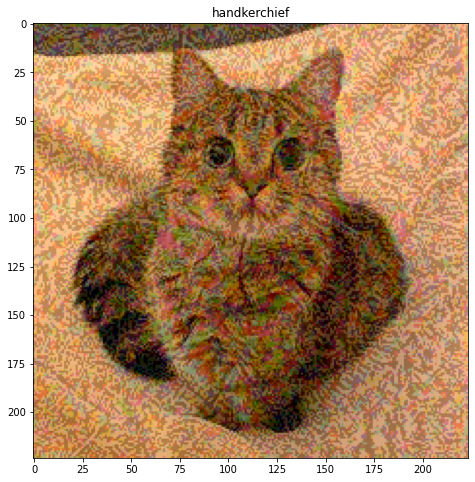

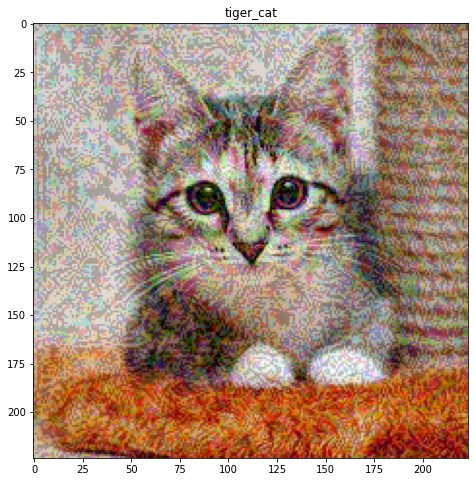

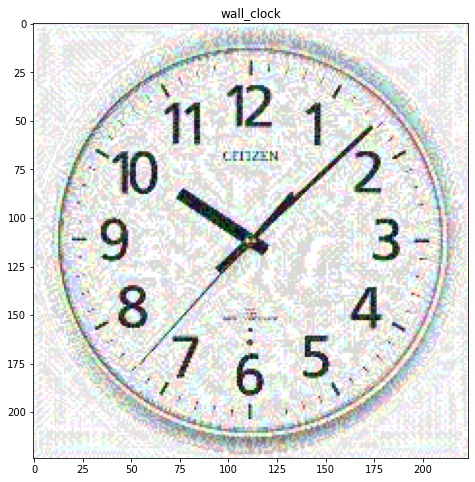

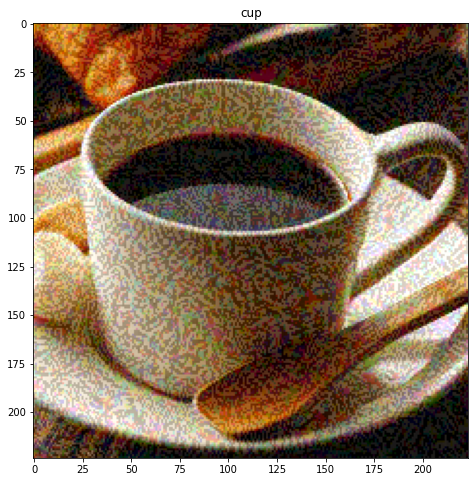

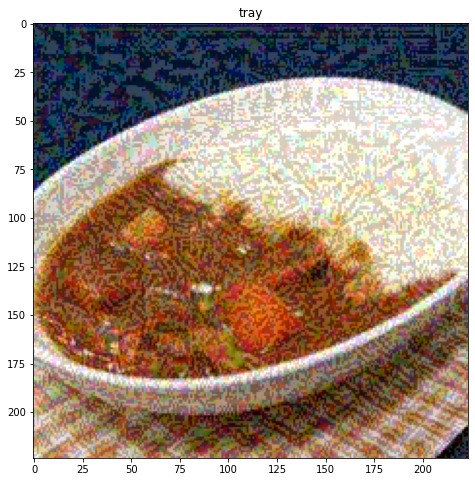

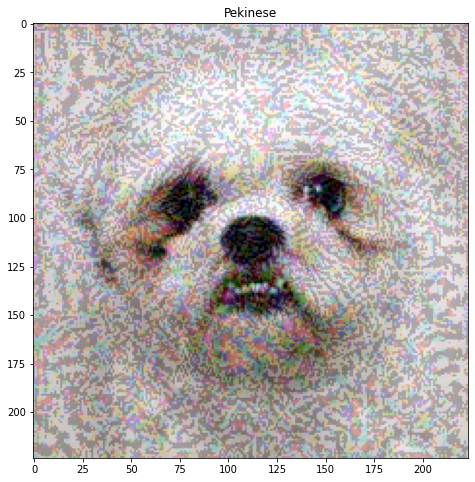

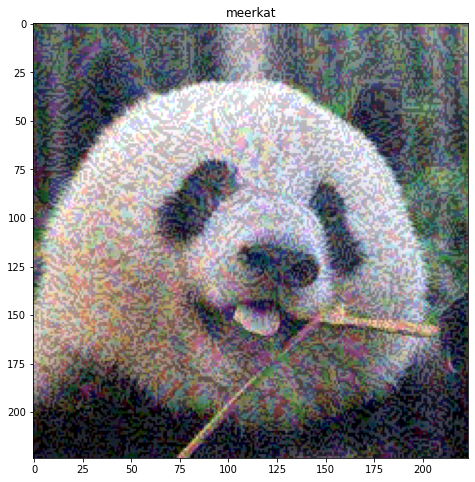

In [43]:
# 画像の枚数分ループ
for image_path in runner_io.inventory('data_image_inventory'):
    # 画像読み込み
    image_name = os.path.basename(image_path)
    image = read_image(image_path)

    # 推論
    image_probs = model.predict(image)

    # 敵対的サンプル生成
    adv_x = create_adversarial_image(image, image_probs)

    label = labels[np.argmax(model.predict(adv_x))]
    plt.figure()
    plt.imshow(adv_x[0]);
    plt.title(label)

    # ファイル出力
    output_name = image_name
    if not (output_name in '.png'):
        output_name = output_name + '.png'
    os.makedirs('artifact', exist_ok=True)
    output_path = './artifact/adv_eps=' + str(epsilon) + '_' + output_name
    plt.savefig(output_path)
    runner_io.output(output_path)

In [44]:
## .ipynb -> .py
!jupyter nbconvert --to script dev.ipynb

[NbConvertApp] Converting notebook dev.ipynb to script
[NbConvertApp] Writing 3510 bytes to dev.py


In [ ]:
## copy ./dev.py ../repository/entrypoint.py
!cp ./dev.py ../repository/entrypoint.py